# CPA 재 분석
- `enter.lesson_page` (레슨 시작)
- `complete.subscription` (첫 결제 완료)
- `complete.lesson` (레슨 완료)
- 위 테이블을 활용해서, CPA를 재분석
- 무료 체험을 사용한 유저들의 체험 기간 내 소비되는 레슨 수를 확인
- 각 유저 별 CPA를 설정하여, LTV를 더 확실하게 파악

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

### 분석할 데이터 불러오기

In [12]:
# free_trial_lesson_df (enter.lesson_page) 데이터 불러오기
free_trial_lesson_df = pd.read_csv(
    r"C:\Users\nuwba\Desktop\Codeit_2\중급1_프로젝트\주제2_원본데이터\주제2_구독서비스_프로덕트_데이터분석\enter.lesson_page.csv",
    encoding="utf-8-sig"
)

# first_sub_df (complete.subscription) 데이터 불러오기
first_sub_df = pd.read_csv(
    r"C:\Users\nuwba\Desktop\Codeit_2\중급1_프로젝트\주제2_원본데이터\주제2_구독서비스_프로덕트_데이터분석\complete.subscription.csv",
    encoding="utf-8-sig"
)

# free_trial_df (start.free_trial) 데이터 불러오기
first_trial_df = pd.read_csv(
    r"C:\Users\nuwba\Desktop\Codeit_2\중급1_프로젝트\주제2_원본데이터\주제2_구독서비스_프로덕트_데이터분석\start.free_trial.csv",
    encoding="utf-8-sig"
)

# complete.lesson 불러오기
complete_lesson_df = pd.read_csv(
    r"C:\Users\nuwba\Desktop\Codeit_2\중급1_프로젝트\주제2_원본데이터\주제2_구독서비스_프로덕트_데이터분석\complete.lesson.csv",
    encoding="utf-8-sig"
)

# user_df (구독정보) 불러오기
user_df = pd.read_csv(
    r"C:\Users\nuwba\Desktop\Codeit_2\중급1_프로젝트\4·7J_user_df.csv",
    encoding="utf-8-sig"
)

C:\Users\nuwba\AppData\Local\Temp\ipykernel_8904\2691203236.py:2: DtypeWarning: Columns (9,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  free_trial_lesson_df = pd.read_csv(


---

### 유저 통합 조건

`enter.lesson_page`에서 `is_free_trial` == `True`인 유저만 → 무료 체험 중 레슨에 진입한 유저

`complete.subscription`에서 첫 결제를 완료한 유저만 → **최종적으로 전환된 유저**

In [13]:
# 조건에 해당하는 유저만 필터링
free_trial_users_df = free_trial_lesson_df[
    free_trial_lesson_df['is_free_trial'] == True
]

# 중복 없이 고유 유저 수 세기
num_unique_free_trial_users = free_trial_users_df['user_id'].nunique()

print(f"무료 체험 중 레슨에 진입한 유저 수 (중복 없이): {num_unique_free_trial_users}")

무료 체험 중 레슨에 진입한 유저 수 (중복 없이): 9313


In [15]:
# 1. free_trial_lesson_df
print("▶ free_trial_lesson_df")
print("user_id 결측값 수:", free_trial_lesson_df['user_id'].isnull().sum())
print("user_id 중복값 수:", free_trial_lesson_df.duplicated(subset=['user_id']).sum())

# 2. first_sub_df (complete.subscription)
print("\n▶ first_sub_df")
print("user_id 결측값 수:", first_sub_df['user_id'].isnull().sum())
print("user_id 중복값 수:", first_sub_df.duplicated(subset=['user_id']).sum())

# 3. first_trial_df
print("\n▶ first_trial_df")
print("user_id 결측값 수:", first_trial_df['user_id'].isnull().sum())
print("user_id 중복값 수:", first_trial_df.duplicated(subset=['user_id']).sum())

# 4. complete_lesson_df
print("\n▶ complete_lesson_df")
print("user_id 결측값 수:", complete_lesson_df['user_id'].isnull().sum())
print("user_id 중복값 수:", complete_lesson_df.duplicated(subset=['user_id']).sum())


▶ free_trial_lesson_df
user_id 결측값 수: 1538529
user_id 중복값 수: 20915786

▶ first_sub_df
user_id 결측값 수: 0
user_id 중복값 수: 408

▶ first_trial_df
user_id 결측값 수: 14
user_id 중복값 수: 14311

▶ complete_lesson_df
user_id 결측값 수: 0
user_id 중복값 수: 5355386


### 각 유저의 22 ~ 23년 내 최초 기록만 남기고 결측/중복 제거

In [16]:
def filter_and_get_first(df, time_col):
    # 시간 컬럼을 datetime으로 변환
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    
    # user_id 기준으로 시간 오름차순 정렬 후 첫 번째 기록만 남김
    df_sorted = df.sort_values(by=[time_col])
    df_first = df_sorted.dropna(subset=['user_id']).drop_duplicates(subset=['user_id'], keep='first')

    # 2022년 1월 1일 이후만 남기기
    df_filtered = df_first[df_first[time_col] >= pd.Timestamp("2022-01-01")]
    return df_filtered

# 적용 예시
free_trial_lesson_df = filter_and_get_first(free_trial_lesson_df, 'client_event_time')
first_sub_df = filter_and_get_first(first_sub_df, 'client_event_time')
first_trial_df = filter_and_get_first(first_trial_df, 'client_event_time')
complete_lesson_df = filter_and_get_first(complete_lesson_df, 'client_event_time')

In [ ]:
# 1. free_trial_lesson_df에서 무료 체험 중 레슨 진입한 유저
free_trial_user_ids = set(
    free_trial_lesson_df[free_trial_lesson_df['is_free_trial'] == True]['user_id']
)

# 2. first_trial_df에서 체험 시작한 유저
first_trial_user_ids = set(first_trial_df['user_id'])

# 3. 결제 완료한 유저
first_sub_user_ids = set(first_sub_df['user_id'])

# 결과 계산
converted_from_lesson = free_trial_user_ids & first_sub_user_ids
converted_from_trial_start = first_trial_user_ids & first_sub_user_ids

print(f"1. 무료 체험 중 레슨 진입 유저 중 결제 전환된 유저 수: {len(converted_from_lesson)}")
print(f"2. 무료 체험 시작 이력이 있는 유저 중 결제 전환된 유저 수: {len(converted_from_trial_start)}")

1. 무료 체험 중 레슨 진입 유저 중 결제 전환된 유저 수: 857
2. 무료 체험 시작 이력이 있는 유저 중 결제 전환된 유저 수: 3475


In [18]:
print(f"→ 비율: {len(converted_from_lesson) / len(free_trial_user_ids):.2%}")
print(f"→ 비율: {len(converted_from_trial_start) / len(first_trial_user_ids):.2%}")

→ 비율: 9.74%
→ 비율: 21.31%


---

---

### user_df를 다시 활용하자

In [66]:
# complete.lesson 불러오기
complete_lesson_df = pd.read_csv(
    r"C:\Users\nuwba\Desktop\Codeit_2\중급1_프로젝트\주제2_원본데이터\주제2_구독서비스_프로덕트_데이터분석\complete.lesson.csv",
    encoding="utf-8-sig"
)

In [104]:
user_df

,user_id,first_complete_time,first_cancel_time,plan_type,plan_price,subscription_months,LTR
0,0000572f2ba8079bcefd2760b632e820,2023-03-25 14:40:01.647,2023-12-31 23:59:59.999,1개월 플랜,15920.0,9,143280.000000
1,000087537cbfd934375364218ff10f91,2023-04-08 11:45:01.586,2023-12-31 23:59:59.999,12개월 플랜,131600.0,9,98700.000000
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-29 01:13:51.820,2023-12-31 23:59:59.999,1개월 플랜,15920.0,1,15920.000000
3,000be07bc09ceff42c11978f4a9f1c1a,2022-08-20 13:05:01.083,2023-12-31 23:59:59.999,12개월 플랜,131600.0,16,175466.666667
4,001cd989a26ba664b086b92c364dc9cf,2022-04-28 10:49:02.241,2023-05-13 14:37:47.093,12개월 플랜,131600.0,12,131600.000000
...,...,...,...,...,...,...,...
13889,ffe800abf1a0c00994b2a5b1ce68c681,2023-10-29 18:09:42.524,2023-11-28 19:37:14.236,1개월 플랜,15920.0,1,15920.000000
13890,ffe8f08cd65e082952aca5a3110f5601,2023-11-28 13:56:53.231,2023-12-31 23:59:59.999,1개월 플랜,15920.0,1,15920.000000
13891,ffefd2c23af0e8de9a5bb9aebc498d07,2023-06-25 10:04:08.372,2023-12-31 23:59:59.999,1개월 플랜,15920.0,6,95520.000000
13892,fff219b952002818462faa3746343f09,2022-06-20 02:03:39.500,2022-06-20 07:31:21.873,12개월 플랜,131600.0,12,131600.000000


In [105]:
# 1. 시간형으로 변환
first_trial_df['trial_start_time'] = pd.to_datetime(first_trial_df['client_event_time'])

# 2. user_id 기준 trial_start_time 오름차순 정렬 후, 최초 시작일만 남기기
first_trial_df_sorted = first_trial_df.sort_values(by='trial_start_time')
first_trial_df_cleaned = first_trial_df_sorted[['user_id', 'trial_start_time']].drop_duplicates(subset='user_id', keep='first')

# 3. 병합
user_df['user_id'] = user_df['user_id'].astype(str)
first_trial_df_cleaned['user_id'] = first_trial_df_cleaned['user_id'].astype(str)

user_df_with_trial = pd.merge(
    user_df,
    first_trial_df_cleaned,
    on='user_id',
    how='left'
)

In [106]:
print("무료 체험 시작일이 존재하는 유저 수:", user_df_with_trial['trial_start_time'].notnull().sum())
print("전체 유저 수:", len(user_df_with_trial))

무료 체험 시작일이 존재하는 유저 수: 3488
전체 유저 수: 13894


In [109]:
user_df_with_trial

,user_id,first_complete_time,first_cancel_time,plan_type,plan_price,subscription_months,LTR,trial_start_time,trial_end_time
0,0000572f2ba8079bcefd2760b632e820,2023-03-25 14:40:01.647,2023-12-31 23:59:59.999,1개월 플랜,15920.0,9,143280.000000,2023-03-18 14:39:22.844,2023-03-25 14:39:22.844
1,000087537cbfd934375364218ff10f91,2023-04-08 11:45:01.586,2023-12-31 23:59:59.999,12개월 플랜,131600.0,9,98700.000000,2023-04-01 11:42:25.489,2023-04-08 11:42:25.489
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-29 01:13:51.820,2023-12-31 23:59:59.999,1개월 플랜,15920.0,1,15920.000000,NaT,NaT
3,000be07bc09ceff42c11978f4a9f1c1a,2022-08-20 13:05:01.083,2023-12-31 23:59:59.999,12개월 플랜,131600.0,16,175466.666667,2022-08-13 12:57:40.928,2022-08-20 12:57:40.928
4,001cd989a26ba664b086b92c364dc9cf,2022-04-28 10:49:02.241,2023-05-13 14:37:47.093,12개월 플랜,131600.0,12,131600.000000,2022-04-27 22:50:58.403,2022-05-04 22:50:58.403
...,...,...,...,...,...,...,...,...,...
13889,ffe800abf1a0c00994b2a5b1ce68c681,2023-10-29 18:09:42.524,2023-11-28 19:37:14.236,1개월 플랜,15920.0,1,15920.000000,NaT,NaT
13890,ffe8f08cd65e082952aca5a3110f5601,2023-11-28 13:56:53.231,2023-12-31 23:59:59.999,1개월 플랜,15920.0,1,15920.000000,NaT,NaT
13891,ffefd2c23af0e8de9a5bb9aebc498d07,2023-06-25 10:04:08.372,2023-12-31 23:59:59.999,1개월 플랜,15920.0,6,95520.000000,NaT,NaT
13892,fff219b952002818462faa3746343f09,2022-06-20 02:03:39.500,2022-06-20 07:31:21.873,12개월 플랜,131600.0,12,131600.000000,2022-06-18 21:51:43.460,2022-06-25 21:51:43.460


In [110]:
# trial_start_time이 있는 경우에만 +7일
user_df_with_trial['trial_end_time'] = user_df_with_trial['trial_start_time'] + pd.Timedelta(days=7)
user_df_with_trial

,user_id,first_complete_time,first_cancel_time,plan_type,plan_price,subscription_months,LTR,trial_start_time,trial_end_time
0,0000572f2ba8079bcefd2760b632e820,2023-03-25 14:40:01.647,2023-12-31 23:59:59.999,1개월 플랜,15920.0,9,143280.000000,2023-03-18 14:39:22.844,2023-03-25 14:39:22.844
1,000087537cbfd934375364218ff10f91,2023-04-08 11:45:01.586,2023-12-31 23:59:59.999,12개월 플랜,131600.0,9,98700.000000,2023-04-01 11:42:25.489,2023-04-08 11:42:25.489
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-29 01:13:51.820,2023-12-31 23:59:59.999,1개월 플랜,15920.0,1,15920.000000,NaT,NaT
3,000be07bc09ceff42c11978f4a9f1c1a,2022-08-20 13:05:01.083,2023-12-31 23:59:59.999,12개월 플랜,131600.0,16,175466.666667,2022-08-13 12:57:40.928,2022-08-20 12:57:40.928
4,001cd989a26ba664b086b92c364dc9cf,2022-04-28 10:49:02.241,2023-05-13 14:37:47.093,12개월 플랜,131600.0,12,131600.000000,2022-04-27 22:50:58.403,2022-05-04 22:50:58.403
...,...,...,...,...,...,...,...,...,...
13889,ffe800abf1a0c00994b2a5b1ce68c681,2023-10-29 18:09:42.524,2023-11-28 19:37:14.236,1개월 플랜,15920.0,1,15920.000000,NaT,NaT
13890,ffe8f08cd65e082952aca5a3110f5601,2023-11-28 13:56:53.231,2023-12-31 23:59:59.999,1개월 플랜,15920.0,1,15920.000000,NaT,NaT
13891,ffefd2c23af0e8de9a5bb9aebc498d07,2023-06-25 10:04:08.372,2023-12-31 23:59:59.999,1개월 플랜,15920.0,6,95520.000000,NaT,NaT
13892,fff219b952002818462faa3746343f09,2022-06-20 02:03:39.500,2022-06-20 07:31:21.873,12개월 플랜,131600.0,12,131600.000000,2022-06-18 21:51:43.460,2022-06-25 21:51:43.460


---

In [111]:
# 1. complete.lesson 시간 처리
complete_lesson_df['lesson_complete_time'] = pd.to_datetime(complete_lesson_df['client_event_time'])
complete_lesson_df['user_id'] = complete_lesson_df['user_id'].astype(str)
user_df_with_trial['user_id'] = user_df_with_trial['user_id'].astype(str)

# 2. user_df와 merge (trial_start, trial_end 붙은 상태 기준)
lesson_merged = pd.merge(
    complete_lesson_df[['user_id', 'lesson_complete_time', 'lesson.id', 'content.id']],
    user_df_with_trial[['user_id', 'trial_start_time', 'trial_end_time']],
    on='user_id',
    how='inner'
)

# 3. 체험 기간 내 수강 로그만 필터링
in_trial_lessons = lesson_merged[
    (lesson_merged['lesson_complete_time'] >= lesson_merged['trial_start_time']) &
    (lesson_merged['lesson_complete_time'] < lesson_merged['trial_end_time'])
]

# 4. 유저별 수강 횟수 집계
lesson_counts = in_trial_lessons.groupby('user_id').agg(
    lesson_complete_count_in_trial=('lesson.id', lambda x: len(set(x))),
    content_complete_count_in_trial=('content.id', lambda x: len(set(x)))
).reset_index()

# 5. 원래 user_df_with_trial에 병합
user_df_with_trial = pd.merge(
    user_df_with_trial,
    lesson_counts,
    on='user_id',
    how='left'
)

# 6. 수강 안 한 유저는 0으로 채우기
user_df_with_trial['lesson_complete_count_in_trial'] = user_df_with_trial['lesson_complete_count_in_trial'].fillna(0).astype(int)

# 7. 확인
user_df_with_trial

,user_id,first_complete_time,first_cancel_time,plan_type,plan_price,subscription_months,LTR,trial_start_time,trial_end_time,lesson_complete_count_in_trial,content_complete_count_in_trial
0,0000572f2ba8079bcefd2760b632e820,2023-03-25 14:40:01.647,2023-12-31 23:59:59.999,1개월 플랜,15920.0,9,143280.000000,2023-03-18 14:39:22.844,2023-03-25 14:39:22.844,23,2.0
1,000087537cbfd934375364218ff10f91,2023-04-08 11:45:01.586,2023-12-31 23:59:59.999,12개월 플랜,131600.0,9,98700.000000,2023-04-01 11:42:25.489,2023-04-08 11:42:25.489,2,2.0
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-29 01:13:51.820,2023-12-31 23:59:59.999,1개월 플랜,15920.0,1,15920.000000,NaT,NaT,0,NaN
3,000be07bc09ceff42c11978f4a9f1c1a,2022-08-20 13:05:01.083,2023-12-31 23:59:59.999,12개월 플랜,131600.0,16,175466.666667,2022-08-13 12:57:40.928,2022-08-20 12:57:40.928,82,5.0
4,001cd989a26ba664b086b92c364dc9cf,2022-04-28 10:49:02.241,2023-05-13 14:37:47.093,12개월 플랜,131600.0,12,131600.000000,2022-04-27 22:50:58.403,2022-05-04 22:50:58.403,10,1.0
...,...,...,...,...,...,...,...,...,...,...,...
13889,ffe800abf1a0c00994b2a5b1ce68c681,2023-10-29 18:09:42.524,2023-11-28 19:37:14.236,1개월 플랜,15920.0,1,15920.000000,NaT,NaT,0,NaN
13890,ffe8f08cd65e082952aca5a3110f5601,2023-11-28 13:56:53.231,2023-12-31 23:59:59.999,1개월 플랜,15920.0,1,15920.000000,NaT,NaT,0,NaN
13891,ffefd2c23af0e8de9a5bb9aebc498d07,2023-06-25 10:04:08.372,2023-12-31 23:59:59.999,1개월 플랜,15920.0,6,95520.000000,NaT,NaT,0,NaN
13892,fff219b952002818462faa3746343f09,2022-06-20 02:03:39.500,2022-06-20 07:31:21.873,12개월 플랜,131600.0,12,131600.000000,2022-06-18 21:51:43.460,2022-06-25 21:51:43.460,67,4.0


---

## 각 유저의 구독 기간 내 완료한 content 개수 세기
- lesson 완료한 수가 너무 많다고 판단

In [112]:
from datetime import timedelta

# 사전 전처리
user_df_with_trial['user_id'] = user_df_with_trial['user_id'].astype(str)
complete_lesson_df['user_id'] = complete_lesson_df['user_id'].astype(str)
complete_lesson_df['lesson_complete_time'] = pd.to_datetime(complete_lesson_df['lesson_complete_time'])
user_df_with_trial['first_complete_time'] = pd.to_datetime(user_df_with_trial['first_complete_time'])
user_df_with_trial['first_cancel_time'] = pd.to_datetime(user_df_with_trial['first_cancel_time'])

# Step 1: 실제 구독 종료일 계산 (actual_subscription_end_time)
def calculate_actual_end_time(row):
    complete_time = row['first_complete_time']
    cancel_time = row['first_cancel_time']
    plan = row['plan_type']

    # 케이스 1: 취소 안함 → 해당 연도 12/31 23:59:59
    if pd.isna(cancel_time):
        return pd.Timestamp(f"{complete_time.year}-12-31 23:59:59")

    # 케이스 2: 12월 중 당일취소 → 무조건 12/31로 간주
    if complete_time.month == 12 and cancel_time.date() == complete_time.date():
        return pd.Timestamp(f"{complete_time.year}-12-31 23:59:59")

    # 케이스 3: 취소 + 플랜별 계산
    if plan == '1개월 플랜':
        return cancel_time + timedelta(days=30)
    elif plan == '12개월 플랜':
        return cancel_time + timedelta(days=365)
    else:
        # 예외 처리 (플랜 정보 없음)
        return pd.Timestamp(f"{complete_time.year}-12-31 23:59:59")

user_df_with_trial['actual_subscription_end_time'] = user_df_with_trial.apply(calculate_actual_end_time, axis=1)

# Step 2: 기간 내 content 완료 개수 (중복 제거)
# 필요한 열만 병합
lesson_merged = pd.merge(
    complete_lesson_df[['user_id', 'lesson_complete_time', 'content.id']],
    user_df_with_trial[['user_id', 'first_complete_time', 'actual_subscription_end_time']],
    on='user_id',
    how='inner'
)

# 해당 기간 내 완료한 content.id만 필터링
lesson_in_period = lesson_merged[
    (lesson_merged['lesson_complete_time'] >= lesson_merged['first_complete_time']) &
    (lesson_merged['lesson_complete_time'] <= lesson_merged['actual_subscription_end_time'])
]

# 유저별 고유 content.id 수 세기
content_counts = lesson_in_period.drop_duplicates(['user_id', 'content.id']) \
                                 .groupby('user_id').size().reset_index(name='subscription_complete_content')

# Step 3: user_df_with_trial에 병합
user_df_with_trial = pd.merge(user_df_with_trial, content_counts, on='user_id', how='left')
user_df_with_trial['subscription_complete_content'] = user_df_with_trial['subscription_complete_content'].fillna(0).astype(int)

# Step 4: 컬럼 순서 조정 (plan_price 뒤에 끼워넣기)
cols = user_df_with_trial.columns.tolist()
# 중복 방지를 위해 제거 후 삽입
if 'subscription_complete_content' in cols:
    cols.remove('subscription_complete_content')
insert_idx = cols.index('plan_price') + 1
cols = cols[:insert_idx] + ['subscription_complete_content'] + cols[insert_idx:]
user_df_with_trial = user_df_with_trial[cols]


In [113]:
user_df_with_trial

,user_id,first_complete_time,first_cancel_time,plan_type,plan_price,subscription_complete_content,subscription_months,LTR,trial_start_time,trial_end_time,lesson_complete_count_in_trial,content_complete_count_in_trial,actual_subscription_end_time
0,0000572f2ba8079bcefd2760b632e820,2023-03-25 14:40:01.647,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,9,143280.000000,2023-03-18 14:39:22.844,2023-03-25 14:39:22.844,23,2.0,2024-01-30 23:59:59.999
1,000087537cbfd934375364218ff10f91,2023-04-08 11:45:01.586,2023-12-31 23:59:59.999,12개월 플랜,131600.0,1,9,98700.000000,2023-04-01 11:42:25.489,2023-04-08 11:42:25.489,2,2.0,2024-12-30 23:59:59.999
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-29 01:13:51.820,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,1,15920.000000,NaT,NaT,0,NaN,2024-01-30 23:59:59.999
3,000be07bc09ceff42c11978f4a9f1c1a,2022-08-20 13:05:01.083,2023-12-31 23:59:59.999,12개월 플랜,131600.0,13,16,175466.666667,2022-08-13 12:57:40.928,2022-08-20 12:57:40.928,82,5.0,2024-12-30 23:59:59.999
4,001cd989a26ba664b086b92c364dc9cf,2022-04-28 10:49:02.241,2023-05-13 14:37:47.093,12개월 플랜,131600.0,2,12,131600.000000,2022-04-27 22:50:58.403,2022-05-04 22:50:58.403,10,1.0,2024-05-12 14:37:47.093
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13889,ffe800abf1a0c00994b2a5b1ce68c681,2023-10-29 18:09:42.524,2023-11-28 19:37:14.236,1개월 플랜,15920.0,5,1,15920.000000,NaT,NaT,0,NaN,2023-12-28 19:37:14.236
13890,ffe8f08cd65e082952aca5a3110f5601,2023-11-28 13:56:53.231,2023-12-31 23:59:59.999,1개월 플랜,15920.0,6,1,15920.000000,NaT,NaT,0,NaN,2024-01-30 23:59:59.999
13891,ffefd2c23af0e8de9a5bb9aebc498d07,2023-06-25 10:04:08.372,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,6,95520.000000,NaT,NaT,0,NaN,2024-01-30 23:59:59.999
13892,fff219b952002818462faa3746343f09,2022-06-20 02:03:39.500,2022-06-20 07:31:21.873,12개월 플랜,131600.0,25,12,131600.000000,2022-06-18 21:51:43.460,2022-06-25 21:51:43.460,67,4.0,2023-06-20 07:31:21.873


In [114]:
# 원하는 컬럼 순서 지정
final_columns = [
    'user_id',
    'first_complete_time',
    'first_cancel_time',
    'plan_type',
    'plan_price',
    'subscription_complete_content',
    'subscription_months',
    'LTR',
    'trial_start_time',
    'trial_end_time',
    'lesson_complete_count_in_trial',
    'content_complete_count_in_trial',
    'actual_subscription_end_time'
]

# 컬럼 순서 재정렬
user_df_with_trial = user_df_with_trial[final_columns]
user_df_with_trial

,user_id,first_complete_time,first_cancel_time,plan_type,plan_price,subscription_complete_content,subscription_months,LTR,trial_start_time,trial_end_time,lesson_complete_count_in_trial,content_complete_count_in_trial,actual_subscription_end_time
0,0000572f2ba8079bcefd2760b632e820,2023-03-25 14:40:01.647,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,9,143280.000000,2023-03-18 14:39:22.844,2023-03-25 14:39:22.844,23,2.0,2024-01-30 23:59:59.999
1,000087537cbfd934375364218ff10f91,2023-04-08 11:45:01.586,2023-12-31 23:59:59.999,12개월 플랜,131600.0,1,9,98700.000000,2023-04-01 11:42:25.489,2023-04-08 11:42:25.489,2,2.0,2024-12-30 23:59:59.999
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-29 01:13:51.820,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,1,15920.000000,NaT,NaT,0,NaN,2024-01-30 23:59:59.999
3,000be07bc09ceff42c11978f4a9f1c1a,2022-08-20 13:05:01.083,2023-12-31 23:59:59.999,12개월 플랜,131600.0,13,16,175466.666667,2022-08-13 12:57:40.928,2022-08-20 12:57:40.928,82,5.0,2024-12-30 23:59:59.999
4,001cd989a26ba664b086b92c364dc9cf,2022-04-28 10:49:02.241,2023-05-13 14:37:47.093,12개월 플랜,131600.0,2,12,131600.000000,2022-04-27 22:50:58.403,2022-05-04 22:50:58.403,10,1.0,2024-05-12 14:37:47.093
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13889,ffe800abf1a0c00994b2a5b1ce68c681,2023-10-29 18:09:42.524,2023-11-28 19:37:14.236,1개월 플랜,15920.0,5,1,15920.000000,NaT,NaT,0,NaN,2023-12-28 19:37:14.236
13890,ffe8f08cd65e082952aca5a3110f5601,2023-11-28 13:56:53.231,2023-12-31 23:59:59.999,1개월 플랜,15920.0,6,1,15920.000000,NaT,NaT,0,NaN,2024-01-30 23:59:59.999
13891,ffefd2c23af0e8de9a5bb9aebc498d07,2023-06-25 10:04:08.372,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,6,95520.000000,NaT,NaT,0,NaN,2024-01-30 23:59:59.999
13892,fff219b952002818462faa3746343f09,2022-06-20 02:03:39.500,2022-06-20 07:31:21.873,12개월 플랜,131600.0,25,12,131600.000000,2022-06-18 21:51:43.460,2022-06-25 21:51:43.460,67,4.0,2023-06-20 07:31:21.873


---

## 회원가입 유저 중 무료 체험사용 했지만, 구독 하지 않은 유저

In [95]:
# 파일 경로
file_path = r"C:\Users\nuwba\Desktop\Codeit_2\중급1_프로젝트\주제2_원본데이터\주제2_구독서비스_프로덕트_데이터분석\complete.signup.csv"

# CSV 파일 불러오기
signup_df = pd.read_csv(file_path, encoding="utf-8-sig")

### `signup_df`에서 `user_df_with_trial` user_id와 중복되는 값 삭제

In [115]:
# 전처리: 문자열 타입 통일
signup_df['user_id'] = signup_df['user_id'].astype(str)
user_df_with_trial['user_id'] = user_df_with_trial['user_id'].astype(str)

# user_df_with_trial에 존재하는 user_id 목록
subscribed_user_ids = set(user_df_with_trial['user_id'])

# 중복 제거: 구독하지 않은 회원가입 유저만 남기기
signup_df_filtered = signup_df[~signup_df['user_id'].isin(subscribed_user_ids)].copy()

print(f"중복 제거 후 남은 회원가입 유저 수: {len(signup_df_filtered)}")

중복 제거 후 남은 회원가입 유저 수: 132654


### 회원가입은 했고, 구독은 안 했지만, 무료 체험은 한 유저

In [116]:
# 무료 체험 이력이 있는 유저 목록 (user_id 기준)
first_trial_df['user_id'] = first_trial_df['user_id'].astype(str)
trial_user_ids = set(first_trial_df['user_id'])

# 회원가입은 했지만 구독 안 한 유저 중, 무료 체험 한 유저만 필터링
non_subscribed_trial_users_df = signup_df_filtered[signup_df_filtered['user_id'].isin(trial_user_ids)].copy()

# 중복 제거 (user_id 기준)
non_subscribed_trial_users_df.drop_duplicates(subset='user_id', inplace=True)

print(f"회원가입했고 구독은 안 했지만 무료 체험한 유저 수: {len(non_subscribed_trial_users_df)}")

회원가입했고 구독은 안 했지만 무료 체험한 유저 수: 11128


In [118]:
# 전처리
first_trial_df['user_id'] = first_trial_df['user_id'].astype(str)
complete_lesson_df['user_id'] = complete_lesson_df['user_id'].astype(str)
complete_lesson_df['lesson_complete_time'] = pd.to_datetime(complete_lesson_df['lesson_complete_time'])
first_trial_df['client_event_time'] = pd.to_datetime(first_trial_df['client_event_time'])

# 1. 무료 체험만 한 유저 목록 (총 11,128명)
free_only_user_ids = non_subscribed_trial_users_df['user_id'].astype(str).unique()

# 2. 각 유저의 최초 trial 시작 시간 추출
first_trials = first_trial_df[first_trial_df['user_id'].isin(free_only_user_ids)]
first_trials = first_trials.sort_values(['user_id', 'client_event_time'])
first_trial_start_df = first_trials.groupby('user_id', as_index=False).first()
first_trial_start_df['trial_start_time'] = first_trial_start_df['client_event_time']
first_trial_start_df['trial_end_time'] = first_trial_start_df['trial_start_time'] + pd.Timedelta(days=7)
first_trial_start_df = first_trial_start_df[['user_id', 'trial_start_time', 'trial_end_time']]

# 3. trial 기간 동안 완료한 고유 콘텐츠 수 계산
lesson_filtered = pd.merge(
    complete_lesson_df[['user_id', 'lesson_complete_time', 'content.id']],
    first_trial_start_df,
    on='user_id',
    how='inner'
)

lesson_in_trial = lesson_filtered[
    (lesson_filtered['lesson_complete_time'] >= lesson_filtered['trial_start_time']) &
    (lesson_filtered['lesson_complete_time'] < lesson_filtered['trial_end_time'])
]

content_counts = (
    lesson_in_trial.drop_duplicates(['user_id', 'content.id'])
    .groupby('user_id')
    .agg(content_complete_count_in_trial=('content.id', 'count'))
    .reset_index()
)

# 4. free_users_df 기본 틀 생성
free_users_df = pd.DataFrame({'user_id': free_only_user_ids})

# NaN으로 채울 항목들
free_users_df['first_complete_time'] = pd.NaT
free_users_df['first_cancel_time'] = pd.NaT
free_users_df['plan_type'] = np.nan
free_users_df['actual_subscription_end_time'] = pd.NaT

# 0으로 채울 항목들
free_users_df['plan_price'] = 0
free_users_df['subscription_complete_content'] = 0
free_users_df['subscription_months'] = 0
free_users_df['LTR'] = 0
free_users_df['lesson_complete_count_in_trial'] = 0

# 5. trial_start_time / trial_end_time merge
free_users_df = pd.merge(free_users_df, first_trial_start_df, on='user_id', how='left')

# 6. content_complete_count_in_trial merge
free_users_df = pd.merge(free_users_df, content_counts, on='user_id', how='left')
free_users_df['content_complete_count_in_trial'] = free_users_df['content_complete_count_in_trial'].fillna(0).astype(int)

# 7. 컬럼 순서 맞추기 (user_df_with_trial 기준)
free_users_df = free_users_df[user_df_with_trial.columns.tolist()]

# ✅ 이제 이걸 user_df_with_trial에 붙이면 됨
# 예: 
# final_df = pd.concat([user_df_with_trial, free_users_df], ignore_index=True)


In [119]:
free_users_df

,user_id,first_complete_time,first_cancel_time,plan_type,plan_price,subscription_complete_content,subscription_months,LTR,trial_start_time,trial_end_time,lesson_complete_count_in_trial,content_complete_count_in_trial,actual_subscription_end_time
0,06b6868000a5d576180aca47896d6cce,NaT,NaT,NaN,0,0,0,0,2023-04-05 21:49:36.156,2023-04-12 21:49:36.156,0,1,NaT
1,5544c5475f9c1682c352683b6dcbd005,NaT,NaT,NaN,0,0,0,0,2023-02-20 05:13:43.580,2023-02-27 05:13:43.580,0,2,NaT
2,9c07011e4f5560603ea872e26b2c04eb,NaT,NaT,NaN,0,0,0,0,2023-03-13 07:30:52.581,2023-03-20 07:30:52.581,0,0,NaT
3,40acc1ddfc012f3d2f58a3de95e9e748,NaT,NaT,NaN,0,0,0,0,2023-03-12 08:28:29.384,2023-03-19 08:28:29.384,0,0,NaT
4,b8ff0f8275e310027a91f3df3de74e5c,NaT,NaT,NaN,0,0,0,0,2023-03-19 07:40:41.725,2023-03-26 07:40:41.725,0,1,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11123,f095e292083223c9d60173f0a4173c26,NaT,NaT,NaN,0,0,0,0,2022-05-28 04:26:30.754,2022-06-04 04:26:30.754,0,0,NaT
11124,d4488d048e462d6c5b69e861d35dcc6b,NaT,NaT,NaN,0,0,0,0,2022-02-21 04:56:12.117,2022-02-28 04:56:12.117,0,0,NaT
11125,b24c5e133d159c222668607cc601d89b,NaT,NaT,NaN,0,0,0,0,2022-02-21 06:07:23.982,2022-02-28 06:07:23.982,0,0,NaT
11126,a318b7d752a63d5d2302a4493835bc10,NaT,NaT,NaN,0,0,0,0,2022-02-21 04:13:10.443,2022-02-28 04:13:10.443,0,0,NaT


In [120]:
final_df = pd.concat([user_df_with_trial, free_users_df], ignore_index=True)

final_df

,user_id,first_complete_time,first_cancel_time,plan_type,plan_price,subscription_complete_content,subscription_months,LTR,trial_start_time,trial_end_time,lesson_complete_count_in_trial,content_complete_count_in_trial,actual_subscription_end_time
0,0000572f2ba8079bcefd2760b632e820,2023-03-25 14:40:01.647,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,9,143280.000000,2023-03-18 14:39:22.844,2023-03-25 14:39:22.844,23,2.0,2024-01-30 23:59:59.999
1,000087537cbfd934375364218ff10f91,2023-04-08 11:45:01.586,2023-12-31 23:59:59.999,12개월 플랜,131600.0,1,9,98700.000000,2023-04-01 11:42:25.489,2023-04-08 11:42:25.489,2,2.0,2024-12-30 23:59:59.999
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-29 01:13:51.820,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,1,15920.000000,NaT,NaT,0,NaN,2024-01-30 23:59:59.999
3,000be07bc09ceff42c11978f4a9f1c1a,2022-08-20 13:05:01.083,2023-12-31 23:59:59.999,12개월 플랜,131600.0,13,16,175466.666667,2022-08-13 12:57:40.928,2022-08-20 12:57:40.928,82,5.0,2024-12-30 23:59:59.999
4,001cd989a26ba664b086b92c364dc9cf,2022-04-28 10:49:02.241,2023-05-13 14:37:47.093,12개월 플랜,131600.0,2,12,131600.000000,2022-04-27 22:50:58.403,2022-05-04 22:50:58.403,10,1.0,2024-05-12 14:37:47.093
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25017,f095e292083223c9d60173f0a4173c26,NaT,NaT,NaN,0.0,0,0,0.000000,2022-05-28 04:26:30.754,2022-06-04 04:26:30.754,0,0.0,NaT
25018,d4488d048e462d6c5b69e861d35dcc6b,NaT,NaT,NaN,0.0,0,0,0.000000,2022-02-21 04:56:12.117,2022-02-28 04:56:12.117,0,0.0,NaT
25019,b24c5e133d159c222668607cc601d89b,NaT,NaT,NaN,0.0,0,0,0.000000,2022-02-21 06:07:23.982,2022-02-28 06:07:23.982,0,0.0,NaT
25020,a318b7d752a63d5d2302a4493835bc10,NaT,NaT,NaN,0.0,0,0,0.000000,2022-02-21 04:13:10.443,2022-02-28 04:13:10.443,0,0.0,NaT


## content 한 건당 값어치

In [ ]:
# 1. 구독 유저만 필터링
subscribed_df = final_df[final_df['first_complete_time'].notna()].copy()

# # 2. 콘텐츠 수 0인 유저 제거 (0으로 나누는 오류 방지)
# subscribed_df = subscribed_df[subscribed_df['subscription_complete_content'] > 0]

# 3. 콘텐츠 1건당 수익 계산

콘텐츠 1건당 값어치: inf


In [141]:
15920 / (subscribed_df['subscription_complete_content'] / subscribed_df["subscription_months"]).mean()

np.float64(7743.935775530086)

In [136]:
subscribed_df

,user_id,first_complete_time,first_cancel_time,plan_type,plan_price,subscription_complete_content,subscription_months,LTR,trial_start_time,trial_end_time,lesson_complete_count_in_trial,content_complete_count_in_trial,actual_subscription_end_time,CPA,LTV,cost_per_content
0,0000572f2ba8079bcefd2760b632e820,2023-03-25 14:40:01.647,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,9,143280.000000,2023-03-18 14:39:22.844,2023-03-25 14:39:22.844,23,2.0,2024-01-30 23:59:59.999,51939.82,91340.180000,71640.000000
1,000087537cbfd934375364218ff10f91,2023-04-08 11:45:01.586,2023-12-31 23:59:59.999,12개월 플랜,131600.0,1,9,98700.000000,2023-04-01 11:42:25.489,2023-04-08 11:42:25.489,2,2.0,2024-12-30 23:59:59.999,51939.82,46760.180000,98700.000000
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-29 01:13:51.820,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,1,15920.000000,NaT,NaT,0,NaN,2024-01-30 23:59:59.999,NaN,15920.000000,7960.000000
3,000be07bc09ceff42c11978f4a9f1c1a,2022-08-20 13:05:01.083,2023-12-31 23:59:59.999,12개월 플랜,131600.0,13,16,175466.666667,2022-08-13 12:57:40.928,2022-08-20 12:57:40.928,82,5.0,2024-12-30 23:59:59.999,129849.55,45617.116667,13497.435897
4,001cd989a26ba664b086b92c364dc9cf,2022-04-28 10:49:02.241,2023-05-13 14:37:47.093,12개월 플랜,131600.0,2,12,131600.000000,2022-04-27 22:50:58.403,2022-05-04 22:50:58.403,10,1.0,2024-05-12 14:37:47.093,25969.91,105630.090000,65800.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13889,ffe800abf1a0c00994b2a5b1ce68c681,2023-10-29 18:09:42.524,2023-11-28 19:37:14.236,1개월 플랜,15920.0,5,1,15920.000000,NaT,NaT,0,NaN,2023-12-28 19:37:14.236,NaN,15920.000000,3184.000000
13890,ffe8f08cd65e082952aca5a3110f5601,2023-11-28 13:56:53.231,2023-12-31 23:59:59.999,1개월 플랜,15920.0,6,1,15920.000000,NaT,NaT,0,NaN,2024-01-30 23:59:59.999,NaN,15920.000000,2653.333333
13891,ffefd2c23af0e8de9a5bb9aebc498d07,2023-06-25 10:04:08.372,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,6,95520.000000,NaT,NaT,0,NaN,2024-01-30 23:59:59.999,NaN,95520.000000,47760.000000
13892,fff219b952002818462faa3746343f09,2022-06-20 02:03:39.500,2022-06-20 07:31:21.873,12개월 플랜,131600.0,25,12,131600.000000,2022-06-18 21:51:43.460,2022-06-25 21:51:43.460,67,4.0,2023-06-20 07:31:21.873,103879.64,27720.360000,5264.000000


In [138]:
subscribed_df["subscription_complete_content"].value_counts(normalize=True)

subscription_complete_content
1     0.151144
2     0.143731
0     0.131136
3     0.112926
4     0.085217
5     0.065712
6     0.058802
7     0.041313
8     0.032532
9     0.029581
10    0.025623
11    0.020081
12    0.015042
13    0.013459
14    0.011948
15    0.010436
16    0.007701
17    0.006478
18    0.006118
20    0.004246
19    0.003671
21    0.003383
22    0.002015
23    0.001943
24    0.001799
27    0.001655
25    0.001511
28    0.001296
29    0.001152
26    0.001152
33    0.000864
31    0.000720
36    0.000720
37    0.000648
39    0.000576
32    0.000504
35    0.000360
34    0.000360
43    0.000288
41    0.000216
48    0.000216
47    0.000216
30    0.000216
73    0.000144
42    0.000144
53    0.000144
44    0.000144
40    0.000144
45    0.000144
49    0.000072
51    0.000072
46    0.000072
38    0.000072
60    0.000072
83    0.000072
Name: proportion, dtype: float64

---

### 콘텐츠 1건당 평균 수익 단가 = 7743.935775530086

In [142]:
# 단가 정의
content_unit_value = 7743.935775530086

# CPA 계산: 콘텐츠 수가 있는 유저만
final_df['CPA'] = np.where(
    final_df['content_complete_count_in_trial'].notna(),
    final_df['content_complete_count_in_trial'] * content_unit_value,
    np.nan
)

# 확인
final_df

,user_id,first_complete_time,first_cancel_time,plan_type,plan_price,subscription_complete_content,subscription_months,LTR,trial_start_time,trial_end_time,lesson_complete_count_in_trial,content_complete_count_in_trial,actual_subscription_end_time,CPA,LTV
0,0000572f2ba8079bcefd2760b632e820,2023-03-25 14:40:01.647,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,9,143280.000000,2023-03-18 14:39:22.844,2023-03-25 14:39:22.844,23,2.0,2024-01-30 23:59:59.999,15487.871551,91340.180000
1,000087537cbfd934375364218ff10f91,2023-04-08 11:45:01.586,2023-12-31 23:59:59.999,12개월 플랜,131600.0,1,9,98700.000000,2023-04-01 11:42:25.489,2023-04-08 11:42:25.489,2,2.0,2024-12-30 23:59:59.999,15487.871551,46760.180000
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-29 01:13:51.820,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,1,15920.000000,NaT,NaT,0,NaN,2024-01-30 23:59:59.999,NaN,15920.000000
3,000be07bc09ceff42c11978f4a9f1c1a,2022-08-20 13:05:01.083,2023-12-31 23:59:59.999,12개월 플랜,131600.0,13,16,175466.666667,2022-08-13 12:57:40.928,2022-08-20 12:57:40.928,82,5.0,2024-12-30 23:59:59.999,38719.678878,45617.116667
4,001cd989a26ba664b086b92c364dc9cf,2022-04-28 10:49:02.241,2023-05-13 14:37:47.093,12개월 플랜,131600.0,2,12,131600.000000,2022-04-27 22:50:58.403,2022-05-04 22:50:58.403,10,1.0,2024-05-12 14:37:47.093,7743.935776,105630.090000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25017,f095e292083223c9d60173f0a4173c26,NaT,NaT,NaN,0.0,0,0,0.000000,2022-05-28 04:26:30.754,2022-06-04 04:26:30.754,0,0.0,NaT,0.000000,-0.000000
25018,d4488d048e462d6c5b69e861d35dcc6b,NaT,NaT,NaN,0.0,0,0,0.000000,2022-02-21 04:56:12.117,2022-02-28 04:56:12.117,0,0.0,NaT,0.000000,-0.000000
25019,b24c5e133d159c222668607cc601d89b,NaT,NaT,NaN,0.0,0,0,0.000000,2022-02-21 06:07:23.982,2022-02-28 06:07:23.982,0,0.0,NaT,0.000000,-0.000000
25020,a318b7d752a63d5d2302a4493835bc10,NaT,NaT,NaN,0.0,0,0,0.000000,2022-02-21 04:13:10.443,2022-02-28 04:13:10.443,0,0.0,NaT,0.000000,-0.000000


In [143]:
# NaN 처리
final_df['CPA_filled'] = final_df['CPA'].fillna(0)
final_df['LTR_filled'] = final_df['LTR'].fillna(0)

# 무료 체험 여부: trial_start_time 존재 여부로 판단
final_df['LTV'] = np.where(
    final_df['trial_start_time'].notna() & (final_df['LTR_filled'] > 0),
    final_df['LTR_filled'] - final_df['CPA_filled'],  # 무료 체험 + 구독
    np.where(
        final_df['LTR_filled'] > 0,
        final_df['LTR_filled'],                        # 비체험 구독
        -final_df['CPA_filled']                        # 무료 체험만 (구독 X → 손실)
    )
)

# 임시 컬럼 정리
final_df.drop(columns=['CPA_filled', 'LTR_filled'], inplace=True)

final_df

,user_id,first_complete_time,first_cancel_time,plan_type,plan_price,subscription_complete_content,subscription_months,LTR,trial_start_time,trial_end_time,lesson_complete_count_in_trial,content_complete_count_in_trial,actual_subscription_end_time,CPA,LTV
0,0000572f2ba8079bcefd2760b632e820,2023-03-25 14:40:01.647,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,9,143280.000000,2023-03-18 14:39:22.844,2023-03-25 14:39:22.844,23,2.0,2024-01-30 23:59:59.999,15487.871551,127792.128449
1,000087537cbfd934375364218ff10f91,2023-04-08 11:45:01.586,2023-12-31 23:59:59.999,12개월 플랜,131600.0,1,9,98700.000000,2023-04-01 11:42:25.489,2023-04-08 11:42:25.489,2,2.0,2024-12-30 23:59:59.999,15487.871551,83212.128449
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-29 01:13:51.820,2023-12-31 23:59:59.999,1개월 플랜,15920.0,2,1,15920.000000,NaT,NaT,0,NaN,2024-01-30 23:59:59.999,NaN,15920.000000
3,000be07bc09ceff42c11978f4a9f1c1a,2022-08-20 13:05:01.083,2023-12-31 23:59:59.999,12개월 플랜,131600.0,13,16,175466.666667,2022-08-13 12:57:40.928,2022-08-20 12:57:40.928,82,5.0,2024-12-30 23:59:59.999,38719.678878,136746.987789
4,001cd989a26ba664b086b92c364dc9cf,2022-04-28 10:49:02.241,2023-05-13 14:37:47.093,12개월 플랜,131600.0,2,12,131600.000000,2022-04-27 22:50:58.403,2022-05-04 22:50:58.403,10,1.0,2024-05-12 14:37:47.093,7743.935776,123856.064224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25017,f095e292083223c9d60173f0a4173c26,NaT,NaT,NaN,0.0,0,0,0.000000,2022-05-28 04:26:30.754,2022-06-04 04:26:30.754,0,0.0,NaT,0.000000,-0.000000
25018,d4488d048e462d6c5b69e861d35dcc6b,NaT,NaT,NaN,0.0,0,0,0.000000,2022-02-21 04:56:12.117,2022-02-28 04:56:12.117,0,0.0,NaT,0.000000,-0.000000
25019,b24c5e133d159c222668607cc601d89b,NaT,NaT,NaN,0.0,0,0,0.000000,2022-02-21 06:07:23.982,2022-02-28 06:07:23.982,0,0.0,NaT,0.000000,-0.000000
25020,a318b7d752a63d5d2302a4493835bc10,NaT,NaT,NaN,0.0,0,0,0.000000,2022-02-21 04:13:10.443,2022-02-28 04:13:10.443,0,0.0,NaT,0.000000,-0.000000


In [131]:
# 무료 체험 이력은 있으나 구독 기록은 없는 유저
check_df = final_df[
    final_df['trial_start_time'].notna() &             # 무료 체험 했고
    final_df['first_complete_time'].isna()             # 구독은 안 한 유저
].copy()

# LTV, CPA, 콘텐츠 소비량 함께 보기
check_df

,user_id,first_complete_time,first_cancel_time,plan_type,plan_price,subscription_complete_content,subscription_months,LTR,trial_start_time,trial_end_time,lesson_complete_count_in_trial,content_complete_count_in_trial,actual_subscription_end_time,CPA,LTV
13894,06b6868000a5d576180aca47896d6cce,NaT,NaT,NaN,0.0,0,0,0.0,2023-04-05 21:49:36.156,2023-04-12 21:49:36.156,0,1.0,NaT,25969.91,-25969.91
13895,5544c5475f9c1682c352683b6dcbd005,NaT,NaT,NaN,0.0,0,0,0.0,2023-02-20 05:13:43.580,2023-02-27 05:13:43.580,0,2.0,NaT,51939.82,-51939.82
13896,9c07011e4f5560603ea872e26b2c04eb,NaT,NaT,NaN,0.0,0,0,0.0,2023-03-13 07:30:52.581,2023-03-20 07:30:52.581,0,0.0,NaT,0.00,-0.00
13897,40acc1ddfc012f3d2f58a3de95e9e748,NaT,NaT,NaN,0.0,0,0,0.0,2023-03-12 08:28:29.384,2023-03-19 08:28:29.384,0,0.0,NaT,0.00,-0.00
13898,b8ff0f8275e310027a91f3df3de74e5c,NaT,NaT,NaN,0.0,0,0,0.0,2023-03-19 07:40:41.725,2023-03-26 07:40:41.725,0,1.0,NaT,25969.91,-25969.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25017,f095e292083223c9d60173f0a4173c26,NaT,NaT,NaN,0.0,0,0,0.0,2022-05-28 04:26:30.754,2022-06-04 04:26:30.754,0,0.0,NaT,0.00,-0.00
25018,d4488d048e462d6c5b69e861d35dcc6b,NaT,NaT,NaN,0.0,0,0,0.0,2022-02-21 04:56:12.117,2022-02-28 04:56:12.117,0,0.0,NaT,0.00,-0.00
25019,b24c5e133d159c222668607cc601d89b,NaT,NaT,NaN,0.0,0,0,0.0,2022-02-21 06:07:23.982,2022-02-28 06:07:23.982,0,0.0,NaT,0.00,-0.00
25020,a318b7d752a63d5d2302a4493835bc10,NaT,NaT,NaN,0.0,0,0,0.0,2022-02-21 04:13:10.443,2022-02-28 04:13:10.443,0,0.0,NaT,0.00,-0.00


In [144]:
# 무료 체험자: trial_start_time이 있는 경우
free_trial_users = final_df[final_df['trial_start_time'].notna()]

# 비 체험자: trial_start_time이 없는 경우
non_trial_users = final_df[final_df['trial_start_time'].isna()]

# 평균 LTV 계산
avg_ltv_free = free_trial_users['LTV'].mean()
avg_ltv_non = non_trial_users['LTV'].mean()

print(f"무료 체험자 평균 LTV: {avg_ltv_free:,.2f}")
print(f"비 체험자 평균 LTV: {avg_ltv_non:,.2f}")

무료 체험자 평균 LTV: 13,020.06
비 체험자 평균 LTV: 72,394.98


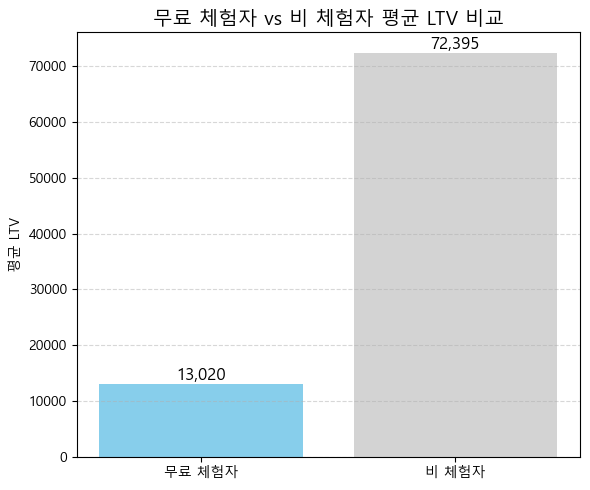

In [145]:
# 그래프 데이터
groups = ['무료 체험자', '비 체험자']
ltv_values = [avg_ltv_free, avg_ltv_non]

# 시각화
plt.figure(figsize=(6,5))
bars = plt.bar(groups, ltv_values, color=['skyblue', 'lightgray'])

# 막대 위 숫자 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:,.0f}", ha='center', va='bottom', fontsize=12)

plt.title('무료 체험자 vs 비 체험자 평균 LTV 비교', fontsize=14)
plt.ylabel('평균 LTV')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()